# Overview
The goal is to make a nice retinopathy model by using a pretrained inception v3 as a base and retraining some modified final layers with attention

This can be massively improved with

high-resolution images
better data sampling
ensuring there is no leaking between training and validation sets, sample(replace = True) is real dangerous
better target variable (age) normalization
pretrained models
attention/related techniques to focus on areas

In [32]:
# copy the weights and configurations for the pre-trained models
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

zsh:1: no matches found: ../input/keras-pretrained-models/*notop*
cp: ../input/keras-pretrained-models/imagenet_class_index.json: No such file or directory


In [33]:
!pip install scikit-image



In [34]:
import sys
sys.executable


'/Users/ankitmehani/Downloads/Notebooks/anaconda3/bin/python'

In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 

In [36]:
base_image_dir = os.path.join('/Users/ankitmehani/VisualStudio/diabetic-retinopathy-detection/')
retina_df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))
retina_df.sample(3)


,image,level
21639,27253_right,0
5101,6429_right,0
2886,3581_left,0


In [37]:
!pip install tensorflow

In [38]:
!pip install --upgrade tensorflow


In [39]:

#This line extracts the patient ID from the 'image' column by splitting the filename at underscores and selecting the first part. It adds this information as a new column named 'PatientId' to the DataFrame.
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])

#This line constructs the file paths for the images by appending the image filenames to the base directory path. It creates a new column named 'path' in the DataFrame to store these paths.
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir, 'train' ,
                                                         '{}.jpeg'.format(x)))

# Check if the image files exist at the specified paths
retina_df['exists'] = retina_df['path'].map(os.path.exists)

#This line checks if the image files exist at the paths specified in the 'path' column. It creates a new boolean column named 'exists' in the DataFrame to indicate whether each image file exists.
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

#1 indicates the left eye and 0 indicates the right eye.
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)


from keras.utils  import to_categorical

#This line encodes the 'level' column using one-hot encoding. It creates a new column named 'level_cat' in the DataFrame to store the encoded labels.
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

#This line removes any rows with missing values (NaNs) from the DataFrame.
retina_df.dropna(inplace = True)

#This line filters the DataFrame to include only the rows where the image files exist.
#retina_df = retina_df[retina_df['exists']]

#This line selects a random sample of 3 rows from the DataFrame for display.
retina_df.sample(3)


35126 images found of 35126 total


,image,level,PatientId,path,exists,eye,level_cat
32792,41381_left,0,41381,/Users/ankitmehani/VisualStudio/diabetic-retin...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
18307,23061_right,0,23061,/Users/ankitmehani/VisualStudio/diabetic-retin...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
27871,35301_right,2,35301,/Users/ankitmehani/VisualStudio/diabetic-retin...,True,0,"[0.0, 0.0, 1.0, 0.0, 0.0]"


# Examine the distribution of eye and severity

array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

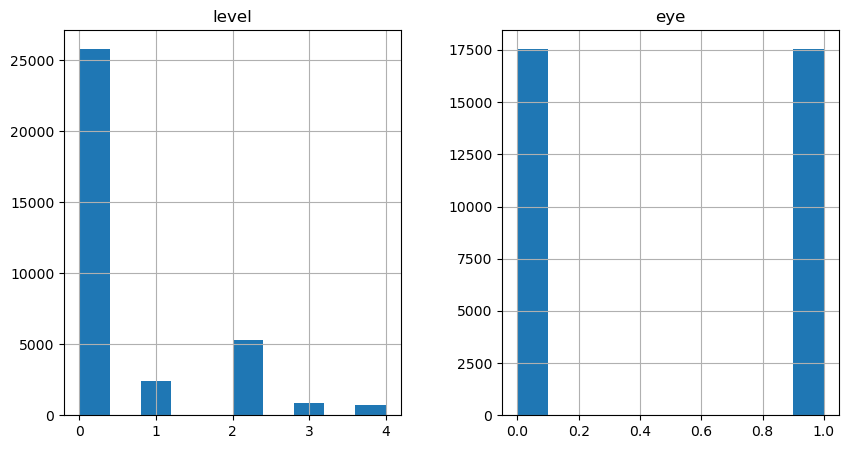

In [40]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

# Split Data into Training and Validation

In [41]:
# !pip install scikit-learn

In [42]:
from sklearn.model_selection import train_test_split

rr_df = retina_df[['PatientId', 'level']].drop_duplicates()

train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])

raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]

valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]

print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 27176 validation 9632


# Balance the distribution in the training set

New Data Size: 750 Old Size: 27176


array([[<Axes: title={'center': 'level'}>,
        <Axes: title={'center': 'eye'}>]], dtype=object)

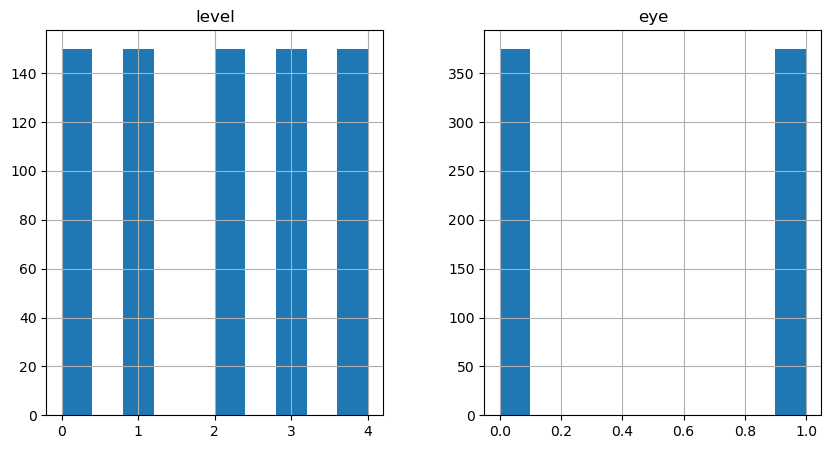

In [43]:
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace = True)
                                                      ).reset_index(drop = True)

print('New Data Size:', train_df.shape[0], 'Old Size:', raw_train_df.shape[0])

train_df[['level', 'eye']].hist(figsize = (10, 5))

In [44]:
import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input
import numpy as np
IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                #X = tf.image.decode_png(tf.read_file(X), channels = 3 if color_mode == 'rgb' else 0)
                X = tf.image.decode_png(tf.io.read_file(X), channels=3 if color_mode == 'rgb' else 0)

                #X = tf.image.resize_images(X, out_size)
                X = tf.image.resize_with_pad(X, out_size[0], out_size[1]) 
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                #angle_rad = rotation_range / 180 * np.pi
                #angles = tf.random.uniform([batch_size], -angle_rad, angle_rad)
                #transforms += [tf.raw_ops.ImageProjectiveTransformV2(angles=angles, output_shape=[intermediate_size[0], intermediate_size[1]])]
                #transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]
                X = tf.image.rot90(X, tf.random.uniform([], 0, 4, dtype=tf.int32))

            if crop_probability > 0:
                #crop_pct = tf.random.uniform([batch_size], min_crop_percent, max_crop_percent)
                #left = tf.random.uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                #top = tf.random.uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                #crop_transform = tf.stack([
                #      crop_pct,
                #      tf.zeros([batch_size]), top,
                #     tf.zeros([batch_size]), crop_pct, left,
                #     tf.zeros([batch_size]),
                #      tf.zeros([batch_size])
                #  ], 1)
                #coin = tf.less(tf.random.uniform([batch_size], 0, 1.0), crop_probability)
                #transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
                X = tf.image.random_crop(X, size=[batch_size, out_size[0], out_size[1], 3])
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            
            if intermediate_trans=='scale':
                 X = tf.image.resize_with_pad(X, out_size[0], out_size[1])
            #    X = tf.image.resize_with_pad(X, out_size[0], out_size[1])
            #    X = tf.image.resize(X, out_size)
            elif intermediate_trans=='crop':
                 X = tf.image.resize_with_crop_or_pad(X, out_size[0], out_size[1])
            #    X = tf.image.resize_with_crop_or_pad(X, out_size[0], out_size[1])
            #    X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline


In [45]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        
        #next_batch = idg(files_ds).repeat().make_one_shot_iterator().get_next()
        next_batch = next(idg(files_ds).repeat().as_numpy_iterator())

        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            #yield K.get_session().run(next_batch)
            #yield tf.compat.v1.Session().run(next_batch)
            yield next_batch



In [46]:
batch_size = 48
core_idg = tf_augmentor(out_size = IMG_SIZE, 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        batch_size = batch_size) 
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                        batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') # we can use much larger batches for evaluation

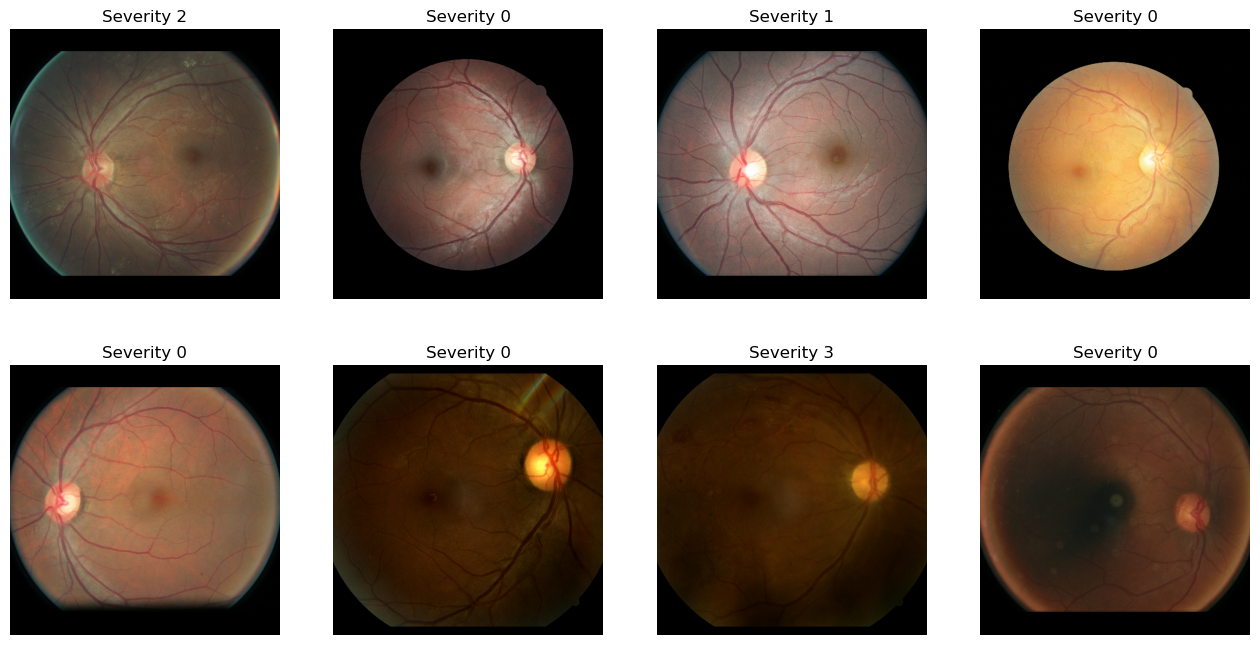

In [47]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')
plt.show()

# Training Set
These are augmented and a real mess

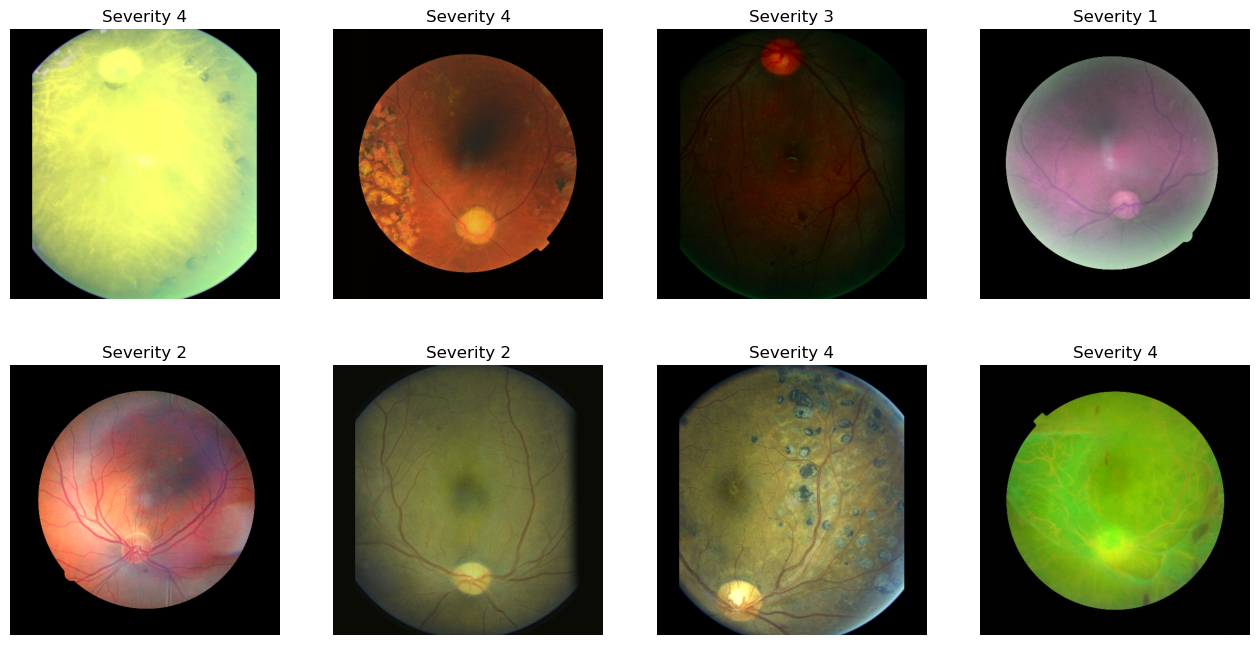

In [48]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

# Attention Model
The basic idea is that a Global Average Pooling is too simplistic since some of the regions are more relevant than others. So we build an attention mechanism to turn pixels in the GAP on an off before the pooling and then rescale (Lambda layer) the results based on the number of pixels. The model could be seen as a sort of 'global weighted average' pooling. There is probably something published about it and it is very similar to the kind of attention models used in NLP. It is largely based on the insight that the winning solution annotated and trained a UNET model to segmenting the hand and transforming it. This seems very tedious if we could just learn attention.

In [49]:
#!pip install keras --upgrade
#!pip install tensorflow --upgrade


In [50]:
import keras
print(keras.__version__)


3.1.1


In [51]:
from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, Lambda
from keras.models import Model




# Now you can use PTModelResNet and PTModelInception to refer to the respective models
in_lay = Input(t_x.shape[1:])



#base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
#base_pretrained_model.trainable = False
#pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
#pt_features = base_pretrained_model(in_lay)


base_pretrained_model = PTModel(input_shape=t_x.shape[1:], include_top=False, weights='imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.output_shape[-1]
pt_features = base_pretrained_model(in_lay)


from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
#up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
#               activation = 'linear', use_bias = False, weights = [up_c2_w])

from keras.initializers import Constant
up_c2 = Conv2D(pt_depth, kernel_size=(1, 1), padding='same', 
               activation='linear', use_bias=False, 
               kernel_initializer=Constant(up_c2_w))




up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)
retina_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import top_k_categorical_accuracy
def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])
retina_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 14, 14,    │ 21,802,784 │ input_layer_2[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      8,192 │ inception_v3[0][… │
│ (BatchNormalizatio… │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_193 (Conv2D) │ (None, 14, 14,    │    131,136 │ dropout_3[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_194 (Conv2D) │ (None, 14, 14,    │      1,040 │ conv2d_193[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_195 (Conv2D) │ (None, 14, 14, 8) │        136 │ conv2d_194[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_196 (Conv2D) │ (None, 14, 14, 1) │          9 │ conv2d_195[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_197 (Conv2D) │ (None, 14, 14,    │      2,048 │ conv2d_196[0][0]  │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 14, 14,    │          0 │ conv2d_197[0][0], │
│ (Multiply)          │ 2048)             │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ conv2d_197[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RescaleGAP (Lambda) │ (None, 2048)      │          0 │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2048)      │          0 │ RescaleGAP[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │    262,272 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 5)         │        645 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,208,262 (84.72 MB)

 Trainable params: 401,382 (1.53 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

In [52]:
weight_path="{}_weights.best.hdf5".format('retina')
weight_path

'retina_weights.best.hdf5'

In [53]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.weights.h5".format('retina')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [54]:
!rm -rf ~/.keras # clean up before starting training

In [55]:
retina_model

<Functional name=functional_3, built=True>

In [69]:
retina_model.fit(train_gen, 
                 steps_per_epoch=train_df.shape[0] // batch_size,
                 validation_data=valid_gen, 
                 validation_steps=valid_df.shape[0] // batch_size,
                 epochs=30, 
                 callbacks=callbacks_list
                )


Epoch 1/30


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6077 - loss: 1.2840 - top_2_accuracy: 0.7864
Epoch 1: val_loss improved from inf to 1.55410, saving model to retina_weights.best.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 702s 50s/step - categorical_accuracy: 0.6175 - loss: 1.2497 - top_2_accuracy: 0.7926 - val_categorical_accuracy: 0.2392 - val_loss: 1.5541 - val_top_2_accuracy: 0.5308 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.8436 - loss: 0.5228 - top_2_accuracy: 0.9061
Epoch 2: val_loss did not improve from 1.55410
15/15 ━━━━━━━━━━━━━━━━━━━━ 703s 50s/step - categorical_accuracy: 0.8374 - loss: 0.5379 - top_2_accuracy: 0.9032 - val_categorical_accuracy: 0.3995 - val_loss: 1.5560 - val_top_2_accuracy: 0.6377 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.9474 - loss: 0.2300 - top_2_accuracy: 0.9958
Epoch 3: val_loss did not improve from 1.55410
15/15 ━━━━━━━━━━━━━━━━━━

In [76]:
# Load the best version of the model
retina_model.load_weights(weight_path)

In [71]:
# Save the model using the native Keras format
retina_model.save('full_retina_model.keras')


In [72]:
from tqdm.notebook import tqdm

# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col='path',
                             y_col='level_cat') 

vbatch_count = (valid_df.shape[0] // batch_size - 1)
out_size = vbatch_count * batch_size

test_X = np.zeros((out_size,) + t_x.shape[1:], dtype=np.float32)
test_Y = np.zeros((out_size,) + t_y.shape[1:], dtype=np.float32)

for i, (c_x, c_y) in zip(tqdm(range(vbatch_count)), valid_gen):
    j = i * batch_size
    test_X[j:(j + c_x.shape[0])] = c_x
    test_Y[j:(j + c_x.shape[0])] = c_y


  0%|          | 0/199 [00:00<?, ?it/s]

## Show Attention
Did our attention model learn anything useful?

In [73]:
import tensorflow as tf

# Iterate over layers starting from the second layer
for i in range(1, len(retina_model.layers)):
    if isinstance(retina_model.layers[i - 1], tf.keras.layers.InputLayer):
        continue
    prev_layer_output_shape = retina_model.layers[i - 1].output.shape
    current_layer = retina_model.layers[i]
    if len(prev_layer_output_shape) == 4:
        #print("Previous layer output shape:", prev_layer_output_shape)
        #print("Current layer:", current_layer)
        # Your code here to print the shape or perform any other operations
        if prev_layer_output_shape[-1]==1:
            print("Previous layer output shape:", prev_layer_output_shape)
            print("Current layer:", current_layer)
            break


Previous layer output shape: (None, 14, 14, 1)
Current layer: <Conv2D name=conv2d_197, built=True>


In [74]:
# Iterate through the layers of the model and print their names and indices
for i, layer in enumerate(retina_model.layers):
    print(f"Layer {i}: {layer.name}")

# Identify the attention layer by its name and retrieve its index
attn_layer_name = "your_attention_layer_name"  # Replace with the name of your attention layer
attn_layer_index = None
for i, layer in enumerate(retina_model.layers):
    if layer.name == attn_layer_name:
        attn_layer_index = i
        break

if attn_layer_index is not None:
    print(f"The index of the attention layer '{attn_layer_name}' is: {attn_layer_index}")
else:
    print(f"Attention layer '{attn_layer_name}' not found in the model.")


Layer 0: input_layer_2
Layer 1: inception_v3
Layer 2: batch_normalization_189
Layer 3: dropout_3
Layer 4: conv2d_193
Layer 5: conv2d_194
Layer 6: conv2d_195
Layer 7: conv2d_196
Layer 8: conv2d_197
Layer 9: multiply_1
Layer 10: global_average_pooling2d_2
Layer 11: global_average_pooling2d_3
Layer 12: RescaleGAP
Layer 13: dropout_4
Layer 14: dense_2
Layer 15: dropout_5
Layer 16: dense_3
Attention layer 'your_attention_layer_name' not found in the model.


In [75]:
attn_layer(0)

TypeError: 'KerasTensor' object is not callable

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


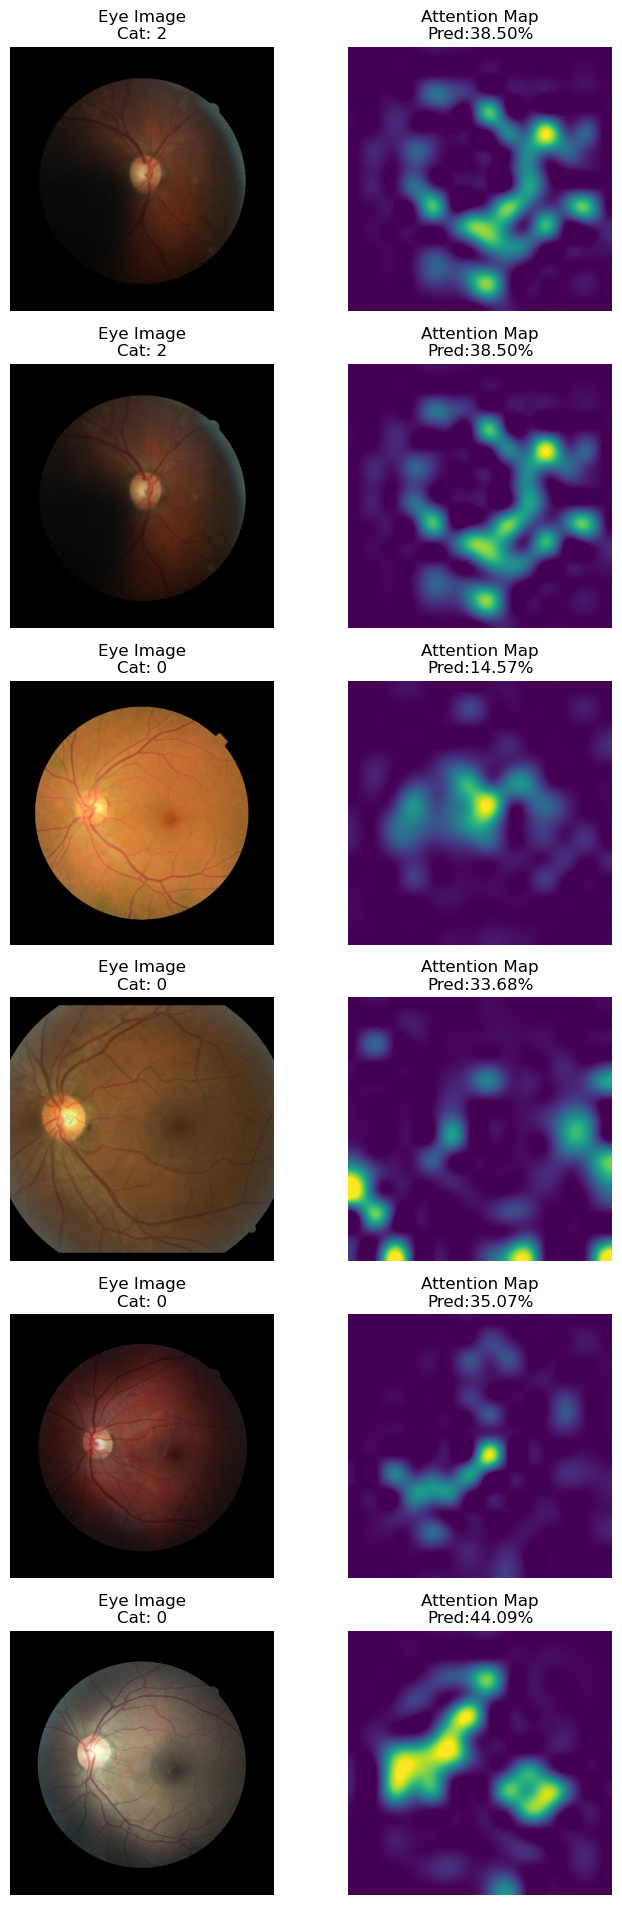

In [77]:
#from tensorflow.keras.models import Model
#from tensorflow.python.keras import backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)

from tensorflow.keras.models import Model
from tensorflow.python.keras import backend as K

# Get the underlying Keras layer from the KerasTensor object
attn_layer_output = attn_layer

# Define a new model that outputs the activations of the desired layer
attn_model = Model(inputs=retina_model.input, outputs=attn_layer_output)

# Compile the new model with the same optimizer and loss function as the original model
attn_model.compile(optimizer=retina_model.optimizer, loss=retina_model.loss)

# Create the function to get the output of the attention layer
def attn_func(input_image):
    return attn_model.predict(input_image)


fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))

[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func(cur_img)
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*127+127, 0, 255).astype(np.uint8))
    attn_ax.imshow(attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max(), cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = retina_model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))
fig.savefig('attention_map.png', dpi = 300)

## Evaluate the results
Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results. We then visualize spec

from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 1 , verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 1 , verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

: 

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)

NameError: name 'test_Y_cat' is not defined

## ROC Curve for healthy vs sick
Here we make an ROC curve for healthy (severity == 0) and sick (severity>0) to see how well the model works at just identifying the disease

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

NameError: name 'test_Y_cat' is not defined

In [ ]:
fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(test_X[idx]*127+127,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)